In [1]:
import pickle
from model_and_circuit import *
from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


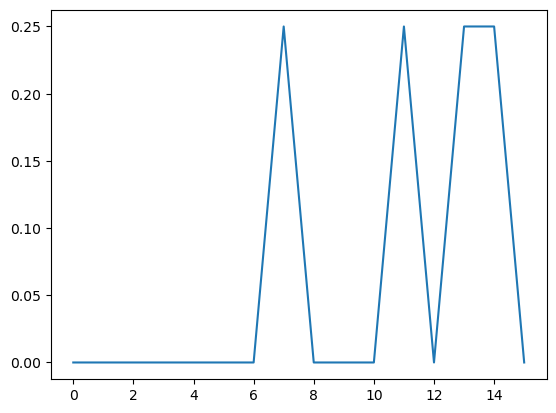

In [2]:
with open("/home/akashm/PROJECT/qcbm_hiwi/qcbm_project/cat_anticat/data/three_particle_distribution.pkl", "rb") as f:
    target_distribution = pickle.load(f)
plt.plot(target_distribution)

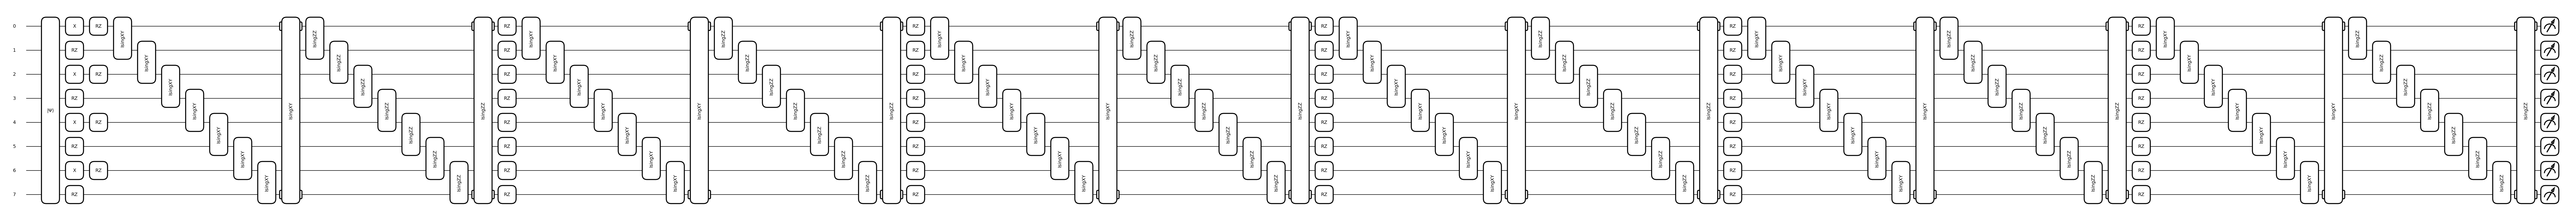

In [3]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show() 

In [4]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return (px @ self.K @ py)
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy) 
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        loss = (self.mmd(px[0],self.py) + 1*jnp.log10(pnumber_distribution(px[1],n_qubits)[1])**2)
        return loss, px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs1 = jnp.asarray(qcbm_probs[0], dtype=jnp.float64)
    qcbm_probs2 = jnp.asarray(qcbm_probs[1], dtype=jnp.float64)
    
    kl_div = (
        -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs1) - jnp.log(target_distribution))) 
        + 1*jnp.log10(pnumber_distribution(qcbm_probs2,n_qubits)[1])**2
        )
    
    return params, opt_state, loss_val, kl_div


In [5]:
# #Load the Checkpoint

# with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model/data_ancilla/model_checkpoint_0.01_13135.pkl', "rb") as file:
#     checkpoint = pickle.load(file)

# start_epoch = checkpoint["final_epoch"] + 1
# weights = checkpoint["parameters"]
# loss_values = checkpoint["history"]
# kl_values = checkpoint["divs"]

# print(f"Resuming training from epoch {start_epoch}...")

In [6]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
# lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.01,staircase=True)
lr = 0.1
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0 
n_epochs = 5001

# while kl_div > 10^-3:
while i < n_epochs:
    i+=1
    # current_lr = lr(i)
    current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.06577689945697784 KL_div:0.6911447644233704 current_lr:0.1 Time taken per iteration: 0.030864953994750977
Step: 20 Loss: 0.014777772128582 KL_div:0.2164384424686432 current_lr:0.1 Time taken per iteration: 0.008640289306640625
Step: 30 Loss: 0.00537590216845274 KL_div:0.12074727565050125 current_lr:0.1 Time taken per iteration: 0.008148431777954102
Step: 40 Loss: 0.002045624889433384 KL_div:0.06976288557052612 current_lr:0.1 Time taken per iteration: 0.013519525527954102
Step: 50 Loss: 0.0006052384851500392 KL_div:0.039990417659282684 current_lr:0.1 Time taken per iteration: 0.00780034065246582
Step: 60 Loss: 0.0003503951884340495 KL_div:0.02976616472005844 current_lr:0.1 Time taken per iteration: 0.007860660552978516
Step: 70 Loss: 0.000223579874727875 KL_div:0.024218251928687096 current_lr:0.1 Time taken per iteration: 0.010133743286132812
Step: 80 Loss: 0.00017550132179167122 KL_div:0.02128986269235611 current_lr:0.1 Time taken per iteration: 0.009867191314697266
St

In [7]:
# import pickle

# #Save Checkpoint
# checkpoint = {"final_epoch":i,
#               "history":history,
#               "divs":divs,
#               "parameters":parameters}

# # with open(f'anticat_model_distribution_copy.pkl','wb') as file:
# with open(f'4qubit_cat_model_checkpoint.pkl','wb') as file:
#     pickle.dump(checkpoint,file)
    
# print("Model saved successfully")

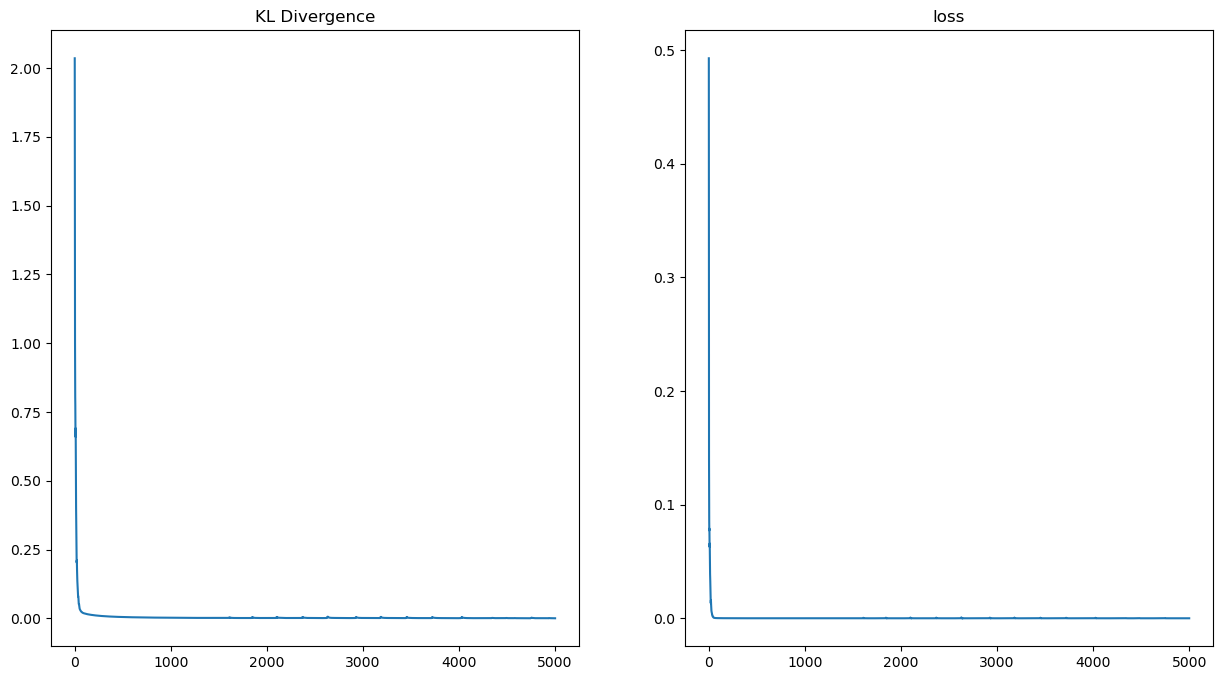

In [8]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

Text(0, 0.5, 'Probability Distribution')

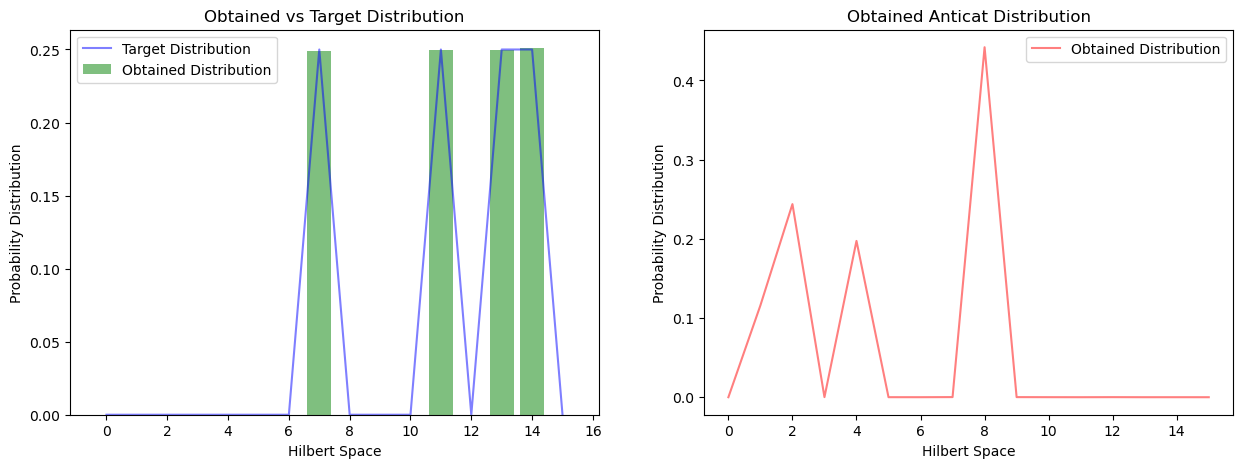

In [9]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].bar(x_full,qcbm_probs[0],color='green',alpha=0.5,label='Obtained Distribution')
axs[0].plot(x_full,target_distribution,color='blue',alpha=0.5,label='Target Distribution')
axs[0].legend()
axs[0].set_title('Obtained vs Target Distribution')
axs[0].set_xlabel('Hilbert Space')
axs[0].set_ylabel('Probability Distribution')

axs[1].plot(x_full,qcbm_probs[1],color='red',alpha=0.5,label='Obtained Distribution')
axs[1].legend()
axs[1].set_title('Obtained Anticat Distribution')
axs[1].set_xlabel('Hilbert Space')
axs[1].set_ylabel('Probability Distribution')


Text(0, 0.5, 'Probability')

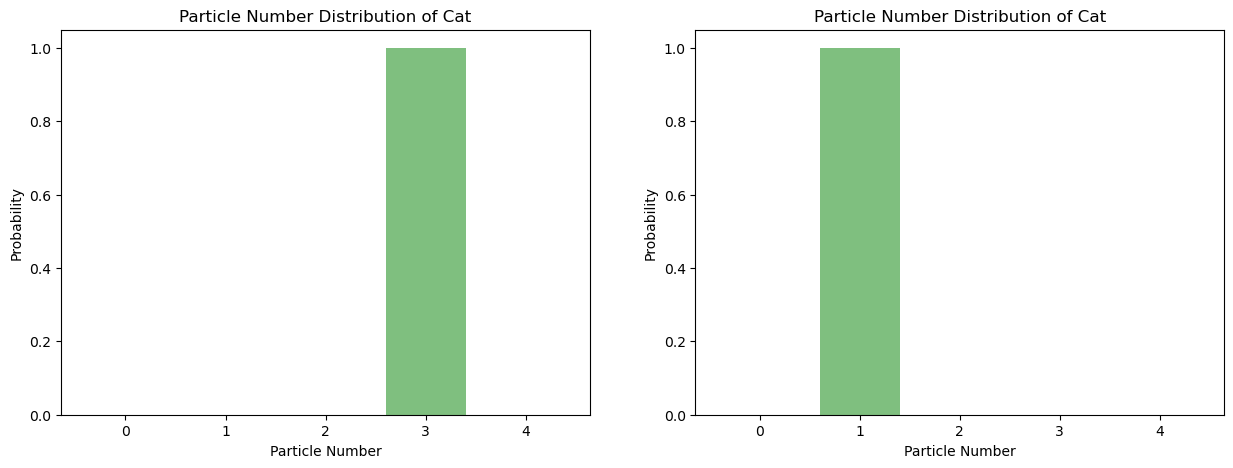

In [10]:
x = jnp.arange(0,n_qubits+1,dtype=jnp.float64)

fig, axs = plt.subplots(1,2,figsize=(15,5))
particle_distribution1 = pnumber_distribution(qcbm_probs[0],n_qubits)
axs[0].bar(x,particle_distribution1,color='green',alpha=0.5,label='Obtained Distribution')
axs[0].set_title('Particle Number Distribution of Cat')
axs[0].set_xlabel('Particle Number')
axs[0].set_ylabel('Probability')

particle_distribution2 = pnumber_distribution(qcbm_probs[1],n_qubits)
axs[1].bar(x,particle_distribution2,color='green',alpha=0.5,label='Obtained Distribution')
axs[1].set_title('Particle Number Distribution of Cat')
axs[1].set_xlabel('Particle Number')
axs[1].set_ylabel('Probability')

In [11]:
print(f"The minimum KL divergence obtained with ancillas, no pretraining and local entanglement : {min(divs)} in {n_epochs} epochs")

The minimum KL divergence obtained with ancillas, no pretraining and local entanglement : 0.0006901325541548431 in 5001 epochs


In [12]:
with open("/home/akashm/PROJECT/qcbm_hiwi/qcbm_project/cat_anticat/data/three_particle_anticat_distribution.pkl", "wb") as f:
    pickle.dump(qcbm_probs[1], f)
    
print("Anticat distribution saved successfully")

Anticat distribution saved successfully
